In [178]:
import os
import re
import pandas as pd
from osgeo import gdal
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
gdal.UseExceptions()

In [171]:
BUCKET = '1182020'
COLLECTION = 'MODIS_land_cover'
EXPORT_PATH = './output/'

In [29]:
# copy metadata from GCP to local
!gsutil -m -q cp -r gs://{BUCKET}/earth_engine/metadata/{COLLECTION} ./metadata

In [13]:
# copy images from GCP to local
!gsutil -m -q cp -r gs://{BUCKET}/earth_engine/images_tif/{COLLECTION} ./images_tif

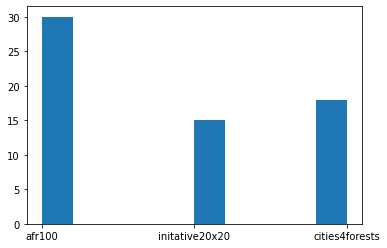

In [180]:
# get countries that have metadata in path (images should be there if metadata is)
p = re.compile('[A-Z]{3}')
countries = [country.replace('.csv', '') for country in os.listdir(F'./metadata/{COLLECTION}') if p.match(country)]

def get_platform_countries():
    areas_by_platform = pd.read_csv('./platforms/areas_served_by_platform.csv')
    country_codes = pd.read_csv('./platforms/country_codes.csv').rename(columns={'country': 'country_clean'})
    countries = areas_by_platform[['platform', 'country', 'country_clean']].drop_duplicates()
    countries = countries.merge(country_codes, how='left', on=['country_clean'])
    return countries

# histogram of countries with collection data, by platform
countries_platforms_all = get_platform_countries()[['platform', 'country', 'alpha3code']]
countries_platforms = countries_platforms_all[countries_platforms_all['alpha3code'].isin(countries)]
plt.hist(countries_platforms['platform'])
plt.show()

In [86]:
def process_images(country):
    metadata = pd.read_csv(F'./metadata/{COLLECTION}/{country}.csv')
    # dict for dates
    img_ts_dict = dict(zip(metadata['image_id'], metadata['image_timestamp']))
    image_ids = metadata['image_id']
    image_fps = [F'./images_tif/{COLLECTION}/{country}/{image_id.replace("/", "-")}.tif' for image_id in image_ids]
    images = [gdal.Open(image_fp).ReadAsArray() for image_fp in image_fps]
    return images, image_ids, img_ts_dict

In [107]:
countries = countries_platforms['alpha3code'].unique()
country = countries[0]
images, image_ids, img_ts_dict = process_images(country)

'2001-01-01 00:00:00+00:00'

In [100]:
# check first image of test country
ds = gdal.Open(F'./images_tif/{COLLECTION}/{country}/{image_ids[0].replace("/", "-")}.tif')
print(ds.GetProjection())
print(ds.GetGeoTransform())

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
(19.295812302887324, 0.008983152841195215, 0.0, 42.69692545420086, 0.0, -0.008983152841195215)


In [61]:
def plot_bands(img, country):
    # care about bands LC_Type1-5
    bands = range(5)
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    for band, ax in zip(bands, axs):
        im = ax.imshow(img[band,:,:])
        ax.axis('off')
        ax.set_title(F"{country}: Band LC_Type{band+1}")
        fig.colorbar(im, ax=ax)

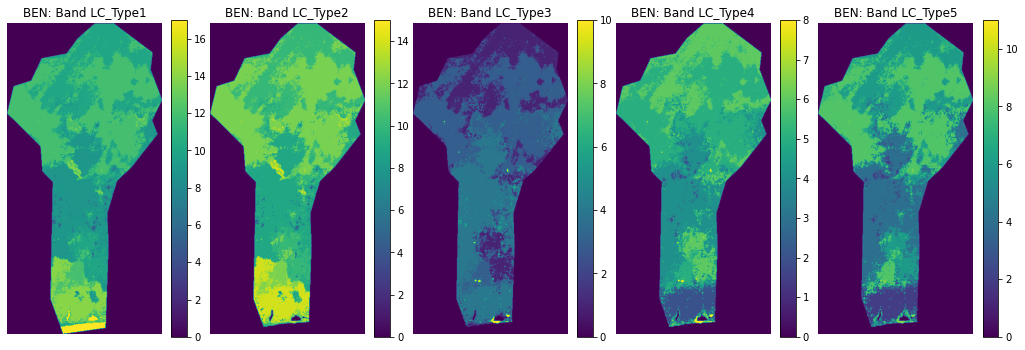

In [109]:
plot_bands(images[1], country)

In [175]:
def pixel_value_counts(img, img_ts, country):
    # annual images
    year = pd.to_datetime(img_ts).year
    # care about bands LC_Type1-5
    bands = range(5)
    dfs = []
    for band in bands:
        img_1d = img[band,:,:].flatten()
        unique, counts = np.unique(img_1d, return_counts=True)
        df = pd.DataFrame({'value': unique, 'count': counts})
        df['alpha3code'] = country
        df['year'] = year
        df['band'] = F'LC_Type{band+1}'
        dfs.append(df)
    df = pd.concat(dfs)
    return df

def all_pixel_value_counts(countries, collection):
    all_dfs = []
    for country in tqdm(countries, total=len(countries), desc='Getting pixel value counts...'):
        images, image_ids, img_ts_dict = process_images(country)
        img_dfs = []
        for img, img_id in zip(images, image_ids):
            img_df = pixel_value_counts(img, img_ts_dict[img_id], country)
            img_dfs.append(img_df)
        all_img_dfs = pd.concat(img_dfs)
        all_dfs.append(all_img_dfs)
    all_dfs = pd.concat(all_dfs)
    return all_dfs

In [181]:
df = all_pixel_value_counts(countries, COLLECTION)
# merge with platform info
df = countries_platforms.merge(df, how='right', on=['alpha3code'])
os.makedirs(EXPORT_PATH, exist_ok=True)
df.to_csv(F'{EXPORT_PATH}{COLLECTION}.csv', index=False)

Getting pixel value counts...: 100%|██████████| 53/53 [03:14<00:00,  3.67s/it]


In [ ]:
# process df to add on band information, groups
# pie charts of land classes for each country, year
# decide which band to use for viz 